Kernel methods are widespread in machine learning and they were particularly common before deep learning became a dominant paradigm. The core idea is to introduce a new notion of distance between high-dimensional data points by replacing the inner product $(x_i, x_j)$ by a function that retains many properties of the inner product, yet which is nonlinear. This function $k(.,.)$ is called a kernel. Then, in many cases, wherever a learning algorithm would use an inner product, the kernel function is used instead.

The intuition is that the kernel function acts as an inner product on a higher dimensional space and encompasses some $\phi(.)$ mapping from the original space of the data points to this space. So intuitively, the kernel function is $k(x_i, x_j)=(\phi(x_i), \phi(x_j))$. The hope is that points that were not linearly separable in the original space become linearly separable in the higher dimensional space. The $\phi(.)$ function may map to an infinite dimensional space and it does not actually have to be specified. As long as the kernel function is positive semidefinite, the idea works.

Many kernel-based learning algorithms are instance-based, which means that the final model retains some or all of the training instances and they play a role in the actual prediction. Support vector machines belong here: support vectors are the training instances which are critically important in defining the boundary between two classes. Some important kernels are listed below.

| Name | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kernel function|
|------|-----------------|
|Linear | $(x_i,x_j)$|
|Polynomial| $((x_i,x_j)+c)^d$|
|Radial basis function|$\exp(-\gamma\|x_i-x_j\|^2)$|

The choice of kernel and the parameters of the kernel are often arbitrary and either some trial and error on the dataset or hyperparameter optimization helps choose the right combination. Quantum computers naturally give rise to certain kernels and it is worth looking at a specific variant of how it is constructed.


# Thinking backward: learning methods based on what the hardware can do

Instead of twisting a machine learning algorithm until only contains subroutines that have quantum variants, we can reverse our thinking and ask: given a piece of quantum hardware and its constraints, can we come up with a new learning method? For instance, interference is a very natural thing to do: we showed an option in the first notebook on quantum states, and it can also be done with a Hadamard gate. For instance, imagine that you have training vectors encoded in some register, and this register is entangled with the $|0\rangle$ in the superposition of an ancilla. The ancilla's $|1\rangle$ of the superposition is entangled with another register that contains the test vector. Applying the Hadamard on the ancilla interferes the test and training instances. Measuring and post-selecting on the ancilla gives rise to a kernel [[1](#1)].

Let's get the basic initialization out of the way:

In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import BasicAer

q = QuantumRegister(4)
c = ClassicalRegister(4)
backend = BasicAer.get_backend('qasm_simulator')

/home/pwittek/.anaconda3/envs/qiskit/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


We are constructing an instance-based classifier: we will calculate a kernel between all training instances and a test example. In this sense, this learning algorithm is lazy: no actual learning happens and each prediction includes the entire training set.

As a consequence, state preparation is critical to this protocol. We have to encode the training instances in a superposition in a register, and the test instances in another register. Consider the following training instances of the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris): $S = \{(\begin{bmatrix}0 \\ 1\end{bmatrix}, 0), (\begin{bmatrix}0.78861006 \\ 0.61489363\end{bmatrix}, 1)\}$, that is, one example from class 0 and one example from class 1. Furthermore, let's have two test instances, $\{\begin{bmatrix}-0.549\\ 0.836\end{bmatrix}, \begin{bmatrix}0.053 \\ 0.999\end{bmatrix}\}$. These examples were cherry-picked because they are relatively straightforward to prepare.

In [2]:
training_set = [[0, 1], [0.78861006, 0.61489363]]
labels = [0, 1]
test_set = [[-0.549, 0.836], [0.053 , 0.999]]

 We use amplitude encoding, which means that, for instance, the second training vector will be encoded as $0.78861006|0\rangle + 0.61489363|1\rangle$. Preparing these vectors only needs a rotation, and we only need to specify the corresponding angles. The first element of the training set does not even need that: it is just the $|1\rangle$ state, so we don't specify an angle for it.

In [3]:
test_angles = [4.30417579487669/2, 3.0357101997648965/2]
training_angle = 1.3245021469658966/4

The following function does the state preparation. We plot it and explain it in more details below.

In [4]:
def prepare_state(q, c, angles):
    ancilla_qubit = q[0]
    index_qubit = q[1]
    data_qubit = q[2]
    class_qubit = q[3]
    qc = QuantumCircuit(q, c)
    # Put the ancilla and the index qubits into uniform superposition
    qc.h(ancilla_qubit)
    qc.h(index_qubit)

    # Prepare the test vector
    qc.cx(ancilla_qubit, data_qubit)
    qc.u3(-angles[0], 0, 0, data_qubit)
    qc.cx(ancilla_qubit, data_qubit)
    qc.u3(angles[0], 0, 0, data_qubit)
    # Flip the ancilla qubit > this moves the input 
    # vector to the |0> state of the ancilla
    qc.x(ancilla_qubit)
    qc.barrier()

    # Prepare the first training vector
    # [0,1] -> class 0
    # We can prepare this with a Toffoli
    qc.ccx(ancilla_qubit, index_qubit, data_qubit)
    # Flip the index qubit > moves the first training vector to the 
    # |0> state of the index qubit
    qc.x(index_qubit)
    qc.barrier()

    # Prepare the second training vector
    # [0.78861, 0.61489] -> class 1

    qc.ccx(ancilla_qubit, index_qubit, data_qubit)
    qc.cx(index_qubit, data_qubit)
    qc.u3(angles[1], 0, 0, data_qubit)
    qc.cx(index_qubit, data_qubit)
    qc.u3(-angles[1], 0, 0, data_qubit)
    qc.ccx(ancilla_qubit, index_qubit, data_qubit)
    qc.cx(index_qubit, data_qubit)
    qc.u3(-angles[1], 0, 0, data_qubit)
    qc.cx(index_qubit, data_qubit)
    qc.u3(angles[1], 0, 0, data_qubit)
    qc.barrier()

    # Flip the class label for training vector #2
    qc.cx(index_qubit, class_qubit)
    qc.barrier()
    return qc

Let us see the circuit for preparing state with the first test instance:

/home/pwittek/.anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)


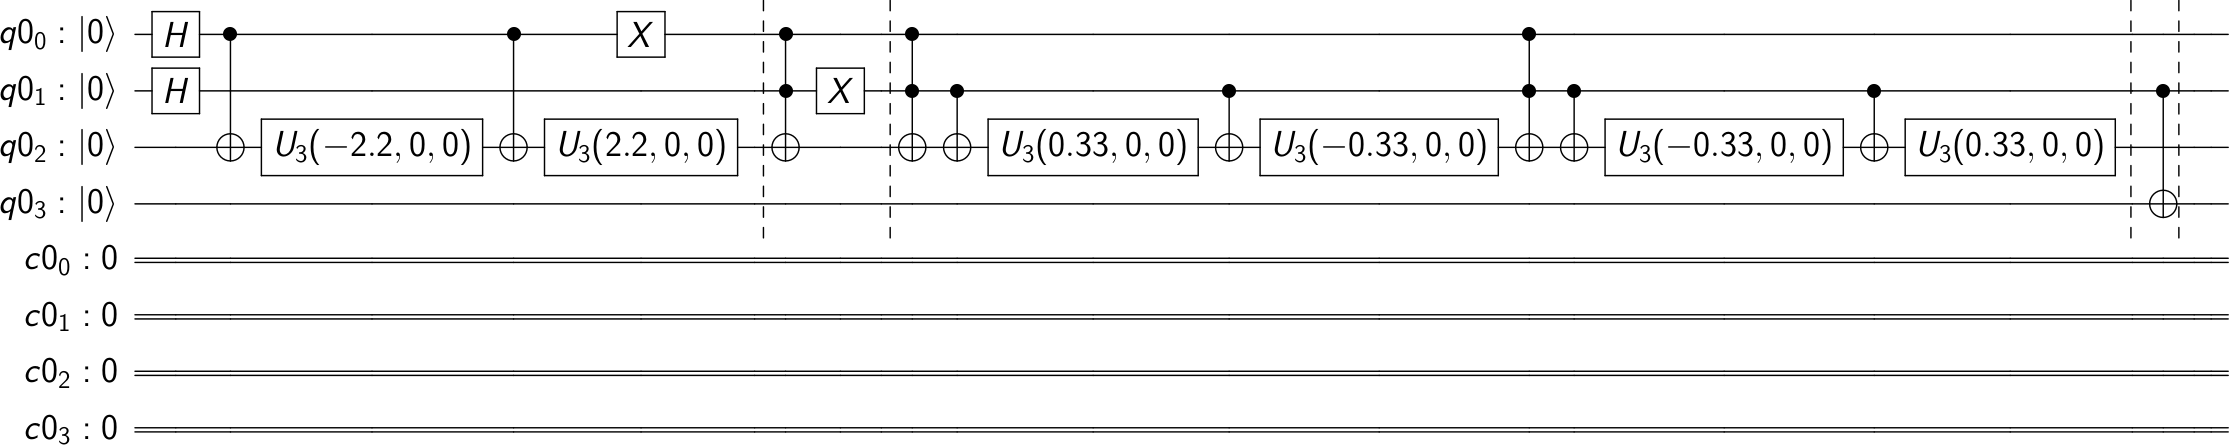

In [5]:
from qiskit.tools.visualization import circuit_drawer
angles = [test_angles[0], training_angle]
state_preparation_0 = prepare_state(q, c, angles)
circuit_drawer(state_preparation_0)

The vertical lines are barriers to make sure that all gates are finished by that point. They also make a natural segmentation of the state preparation.

The test instance is prepared until the first barrier. The ancilla and index qubits (registers 0 and 1) are put into the uniform superposition. The test instance is entangled with the ground state of the ancilla. 

Then between the first and second barriers, we prepare the state $|1\rangle$, which is the first training instance, and entangle it with the excited state of the ancilla and the ground state of the index qubit with a Toffoli gate and a Pauli-X gate. The Toffoli gate is also called the controlled-controlled-not gate, describing its action.

The third section prepares the second training instance and entangles it with the excited state of the ancilla and the index qubit.

The final part flips the class qubit conditioned on the index qubit. This creates the connection between the encoded training instances and the corresponding class label.

# A natural kernel on a shallow circuit

Having down the state preparation, the actual prediction is nothing but a Hadamard gate applied on the ancilla, followed by measurements. Since the ancilla is in a uniform superposition at the end of the state preparation and it is entangled with the registers encoding the test and training instances, applying a second Hadamard on the ancilla interferes the entangled registers. The state before the measurement is $\frac{1}{2\sqrt{2}}\sum_{i=0}^1|0\rangle|i\rangle(|x_t\rangle+|x_i\rangle)|y_i\rangle+|1\rangle|i\rangle(|x_t\rangle-|x_i\rangle)|y_i\rangle$, where $|x_t\rangle$ is the encoded test instance and $|x_i\rangle$ is a training instance.

In [6]:
def interfere_data_and_test_instances(qc, q, c, angles):
    qc.h(q[0])
    qc.barrier()
    qc.measure(q, c)
    return qc

If we measure the ancilla, the outcome probability of observing 0 will be $\frac{1}{4N}\sum_{i=1}^N |x_t + x_i|^2$. This creates a kernel of the following form:

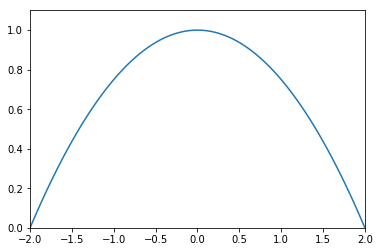

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = np.linspace(-2, 2, 100)
plt.xlim(-2, 2)
plt.ylim(0, 1.1)
plt.plot(x, 1-x**2/4)

This is the kernel that performs the classification. We perform the post-selection on observing 0 on the measurement on the ancilla and calculate the probabilities of the test instance belonging to either class:

In [8]:
def postselect(result_counts):
    total_samples = sum(result_counts.values())

    # define lambda function that retrieves only results where the ancilla is in the |0> state
    post_select = lambda counts: [(state, occurences) for state, occurences in counts.items() if state[-1] == '0']

    # perform the postselection
    postselection = dict(post_select(result_counts))
    postselected_samples = sum(postselection.values())

    print(f'Ancilla post-selection probability was found to be {postselected_samples/total_samples}')

    retrieve_class = lambda binary_class: [occurences for state, occurences in postselection.items() if state[0] == str(binary_class)]

    prob_class0 = sum(retrieve_class(0))/postselected_samples
    prob_class1 = sum(retrieve_class(1))/postselected_samples

    print('Probability for class 0 is', prob_class0)
    print('Probability for class 1 is', prob_class1)

For the first instance we have:

In [9]:
qc0 = interfere_data_and_test_instances(state_preparation_0, q, c, angles)
job = execute(qc0, backend)
result = job.result()
postselect(result.get_counts(qc0))

/home/pwittek/.anaconda3/envs/qiskit/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


Ancilla post-selection probability was found to be 0.701171875
Probability for class 0 is 0.6559888579387186
Probability for class 1 is 0.34401114206128136


/home/pwittek/.anaconda3/envs/qiskit/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


And for the second one:

In [10]:
angles = [test_angles[1], training_angle]
state_preparation_1 = prepare_state(q, c, angles)
qc1 = interfere_data_and_test_instances(state_preparation_1, q, c, angles)
job = execute(qc1, backend)
result = job.result()
postselect(result.get_counts(qc1))

Ancilla post-selection probability was found to be 0.935546875
Probability for class 0 is 0.5501043841336117
Probability for class 1 is 0.4498956158663883


# References

[1] M. Schuld, M. Fingerhuth, F. Petruccione. (2017). [Implementing a distance-based classifier with a quantum interference circuit](https://doi.org/10.1209/0295-5075/119/60002). *Europhysics Letters*, 119(6), 60002. <a id='1'></a>